In [1]:
# importing libraries 

import os
import re

import pandas as pd 
import numpy as np 

import tensorflow as tf
from keras import preprocessing
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/var/folders/4k/byg8gjqx3ld5757qnw63s0v00000gn/T/ipykernel_56488/4111138755.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# data folders

train_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/train'
valid_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/valid'
test_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/test'

In [3]:
# creating a dataframe for the test folder with the images and their class 

test_images_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/test/images'
image_files_test = [file for file in os.listdir(test_images_path) if file.endswith('.jpg')]
class_labels_test = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_test]
test_df = pd.DataFrame({'filename': image_files_test, 'class': class_labels_test})

# creating a dataframe for the train folder with the images and their class 

train_images_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/train/images'
image_files_train = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]
class_labels_train = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_train]
train_df = pd.DataFrame({'filename': image_files_train, 'class': class_labels_train})

# creating a dataframe for the valid folder with the images and their class 

valid_images_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/valid/images'
image_files_valid = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]
class_labels_valid = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_valid]
validation_df = pd.DataFrame({'filename': image_files_valid, 'class': class_labels_valid})

In [4]:
# confirming the creation of the dfs and the classes 

test_df['class'].value_counts()

class
1    22
5    15
4    14
0    13
2    13
3     6
Name: count, dtype: int64

In [5]:
# real-time data augmentation and preparing the data for training 

batch_size = 32  
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_path,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse',  
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=valid_images_path,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_images_path,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode=None,  
    shuffle=False  
)

Found 1804 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Found 83 validated image filenames.


In [6]:
# calling the pre trained model, freezing its layers, adding my layer and its output, and compiling

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)  
predictions = Dense(6, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# training the model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model-original.h5', save_best_only=True)
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=2, callbacks=[early_stopping, checkpoint] )

Epoch 1/20
57/57 - 84s - loss: 1.3803 - accuracy: 0.4767 - val_loss: 0.9069 - val_accuracy: 0.6994 - 84s/epoch - 1s/step
Epoch 2/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 - 91s - loss: 0.8829 - accuracy: 0.6984 - val_loss: 0.7154 - val_accuracy: 0.7688 - 91s/epoch - 2s/step
Epoch 3/20
57/57 - 90s - loss: 0.7489 - accuracy: 0.7489 - val_loss: 0.6755 - val_accuracy: 0.7630 - 90s/epoch - 2s/step
Epoch 4/20
57/57 - 92s - loss: 0.6467 - accuracy: 0.7655 - val_loss: 0.5873 - val_accuracy: 0.7803 - 92s/epoch - 2s/step
Epoch 5/20
57/57 - 93s - loss: 0.6331 - accuracy: 0.7716 - val_loss: 0.6647 - val_accuracy: 0.7341 - 93s/epoch - 2s/step
Epoch 6/20
57/57 - 94s - loss: 0.5675 - accuracy: 0.8004 - val_loss: 0.6144 - val_accuracy: 0.7977 - 94s/epoch - 2s/step
Epoch 7/20
57/57 - 95s - loss: 0.5495 - accuracy: 0.7966 - val_loss: 0.6020 - val_accuracy: 0.7977 - 95s/epoch - 2s/step
Epoch 8/20
57/57 - 95s - loss: 0.5146 - accuracy: 0.8099 - val_loss: 0.5584 - val_accuracy: 0.7803 - 95s/epoch - 2s/step
Epoch 9/20
57/57 - 96s - loss: 0.4900 - accuracy: 0.8259 - val_loss: 0.5826 - val_accuracy: 0.8035 - 96s/epoch - 2s/step
Epoch 10/20
57/57 - 96s - loss: 0.4775 - ac

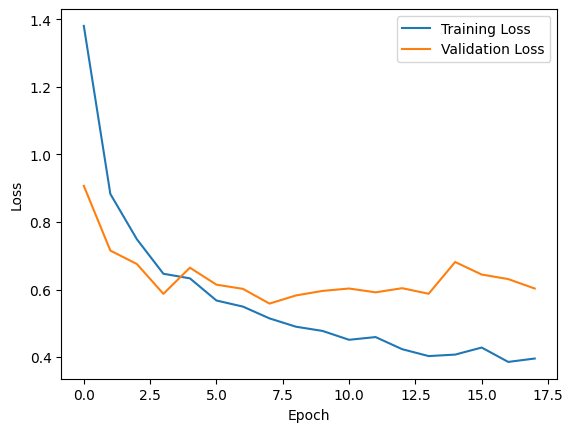

In [12]:
# plotting the val and training loss 

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# evaluating the model on the validation set

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


6/6 [==============================] - 7s 1s/step - loss: 0.5584 - accuracy: 0.7803
Validation Loss: 0.5584167242050171, Validation Accuracy: 0.7803468108177185


In [14]:
# making predictions on the test set

test_predictions = model.predict(test_generator)

# printing the predicted class for each test image

test_predicted_classes = np.argmax(test_predictions, axis=1)
test_df['predicted_class'] = test_predicted_classes
print(test_df)



3/3 [==============================] - 3s 930ms/step
          filename class  predicted_class
0   1_ecfcdf81.jpg     1                1
1   0_37b28d86.jpg     0                0
2   4_617cc4fc.jpg     4                4
3   1_ab5b5d51.jpg     1                1
4   4_f5a9c243.jpg     4                4
..             ...   ...              ...
78  4_76253060.jpg     4                4
79  0_617ae978.jpg     0                1
80  4_0c0be5b2.jpg     4                4
81  1_7093ab43.jpg     1                1
82  3_b592c43a.jpg     3                3

[83 rows x 3 columns]


In [15]:
# calling the true labels for the test set

true_labels = [int(label) for label in test_df['class']]

# accuracy

accuracy = accuracy_score(true_labels, test_predicted_classes)
print(f'Accuracy: {accuracy:.2%}')

# classification report

print('Classification Report:')
print(classification_report(true_labels, test_predicted_classes))

Accuracy: 78.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.67      0.82      0.73        22
           2       0.89      0.62      0.73        13
           3       0.33      0.33      0.33         6
           4       1.00      0.93      0.96        14
           5       0.88      0.93      0.90        15

    accuracy                           0.78        83
   macro avg       0.77      0.73      0.74        83
weighted avg       0.80      0.78      0.78        83

Confusion Matrix:
[[10  3  0  0  0  0]
 [ 0 18  1  3  0  0]
 [ 0  3  8  1  0  1]
 [ 1  3  0  2  0  0]
 [ 0  0  0  0 13  1]
 [ 1  0  0  0  0 14]]
